In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Read files

In [2]:
# Load files into a pandas dataframe

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [3]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [4]:
train.shape

(12079, 14)

In [5]:
test.shape

(5177, 13)

In [6]:
(train['Policy Start Date']==train['First Transaction Date']).all()

True

In [7]:
train.State.nunique()

111

In [8]:
train.Subject_Car_Make.unique()

array(['TOYOTA', nan, 'REXTON', 'Lexus', 'Hyundai', 'Iveco', 'DAF',
       'Honda', 'Mercedes', 'Jincheng', 'ACURA', 'Ford', 'Volkswagen',
       'Nissan', '.', 'Pontiac', 'Range Rover', 'Kia', 'Mitsubishi',
       'Scania', 'BMW', 'Infiniti', 'Renault', 'Volvo', 'Hummer', 'Mack',
       'Grand Cherokee', 'Porsche', 'Peugeot', 'Land Rover', 'Chevrolet',
       'Mazda', 'Man', 'Jeep', 'Audi', 'Suzuki', 'MINI COOPER', 'KA',
       'As Attached', 'Innson', 'Isuzu', 'Skoda', 'Jaguar', 'Chrysler',
       'Dodge', 'GMC', 'Land Rover.', 'Subaru', 'GAC', 'Fiat', 'Opel',
       'Astra', 'Motorcycle', 'ZOYTE', 'Seat', 'FOTON', 'Howo', 'Lincoln',
       'Rols Royce', 'CHANGAN', 'LIBERTY', 'ABG', 'Yamaha', 'Black',
       'Tata', 'Ashok Leyland', 'Geely', 'Caddillac', 'Wrangler Jeep',
       'Raston', 'MG', 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj'],
      dtype=object)

In [9]:
train.ProductName.unique()

array(['Car Classic', 'CarSafe', 'Muuve', 'CVTP', 'Car Plus',
       'Motor Cycle', 'Customized Motor', 'CarFlex', 'Car Vintage'],
      dtype=object)

In [10]:
train['Car_Category'].unique()

array(['Saloon', 'JEEP', nan, 'Motorcycle', 'Truck', 'Bus', 'Mini Bus',
       'Pick Up', 'Mini Van', 'Van', 'Pick Up > 3 Tons', 'CAMRY CAR HIRE',
       'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel',
       'Tipper Truck'], dtype=object)

<AxesSubplot:xlabel='ProductName', ylabel='count'>

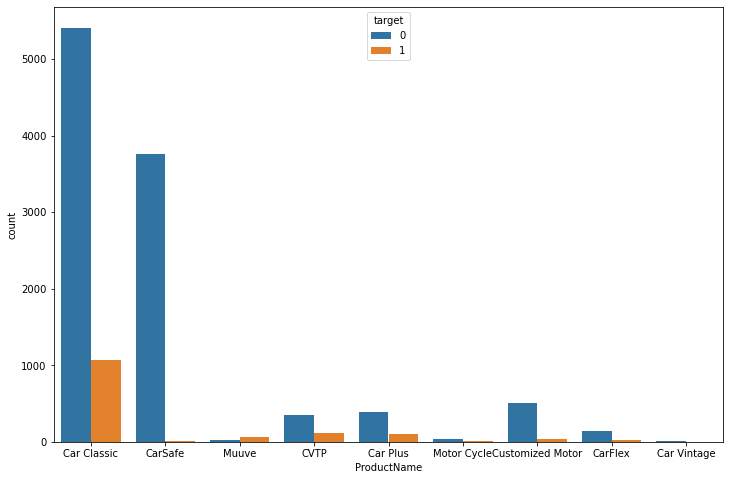

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x='ProductName', hue='target', data= train)

In [12]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_009D84L,2010-04-24,2011-03-27,NO GENDER,25,2010-04-24,1,NaN,As Attached,Iveco,Victoria Island,Lagos,CVTP
1,ID_01DO2EQ,2010-01-01,2010-12-31,NaN,120,2010-01-01,4,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Muuve
2,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
3,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
4,ID_02BYET3,2010-09-16,2010-12-31,NaN,120,2010-09-16,4,NaN,NaN,TOYOTA,Victoria Island,Lagos,Muuve


In [13]:
ss.head()

,ID,target
0,ID_009D84L,0
1,ID_01DO2EQ,0
2,ID_01QM0NU,0
3,ID_024NJLZ,0
4,ID_02BYET3,0


In [14]:
train.LGA_Name.nunique()

258

<AxesSubplot:xlabel='target', ylabel='Density'>

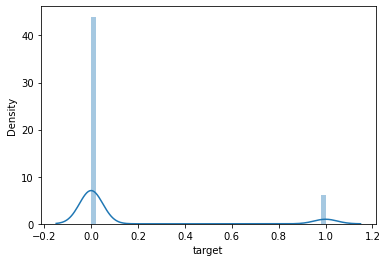

In [15]:
sns.distplot(train.target)

In [16]:
# check the size of the dataset
print("Size of the training set is {}".format(train.shape))
print("Size of the training set is {}".format(test.shape))

Size of the training set is (12079, 14)
Size of the training set is (5177, 13)


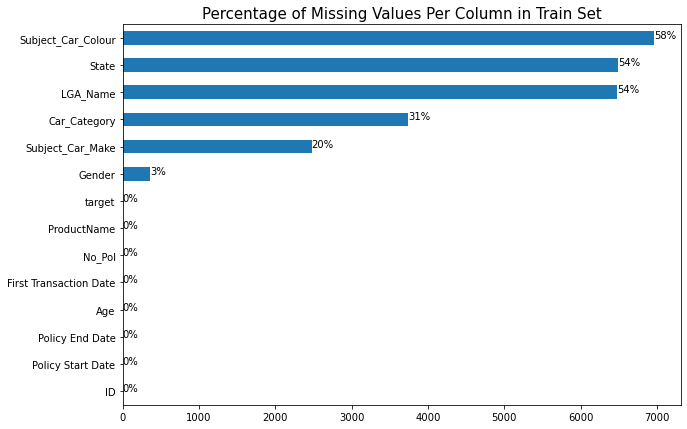

In [17]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [18]:
train.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

In [19]:
train[['State', 'LGA_Name']]

,State,LGA_Name
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,Lagos,Lagos
...,...,...
12074,Ibeju-Lekki,Ibeju/Lekki
12075,NaN,NaN
12076,NaN,NaN
12077,Lagos,Victoria Island


In [20]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (17256, 14)


In [21]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      17256 non-null  object 
 1   Policy Start Date       17256 non-null  object 
 2   Policy End Date         17256 non-null  object 
 3   Gender                  16741 non-null  object 
 4   Age                     17256 non-null  int64  
 5   First Transaction Date  17256 non-null  object 
 6   No_Pol                  17256 non-null  int64  
 7   Car_Category            11880 non-null  object 
 8   Subject_Car_Colour      7289 non-null   object 
 9   Subject_Car_Make        13719 non-null  object 
 10  LGA_Name                7998 non-null   object 
 11  State                   7980 non-null   object 
 12  ProductName             17256 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [22]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      17256 non-null  object        
 1   Policy Start Date       17256 non-null  datetime64[ns]
 2   Policy End Date         17256 non-null  datetime64[ns]
 3   Gender                  16741 non-null  category      
 4   Age                     17256 non-null  int64         
 5   First Transaction Date  17256 non-null  datetime64[ns]
 6   No_Pol                  17256 non-null  int64         
 7   Car_Category            11880 non-null  category      
 8   Subject_Car_Colour      7289 non-null   category      
 9   Subject_Car_Make        13719 non-null  category      
 10  LGA_Name                7998 non-null   category      
 11  State                   7980 non-null   category      
 12  ProductName             17256 non-null  catego

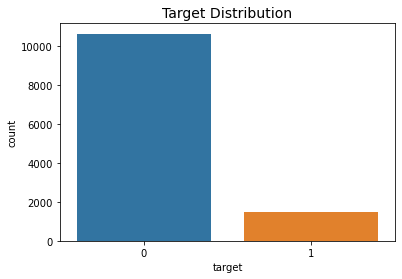

In [23]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

<AxesSubplot:>

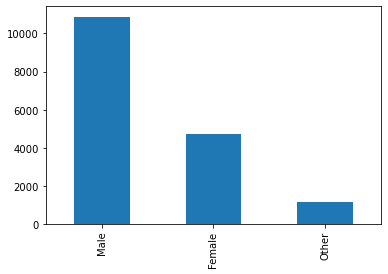

In [24]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts().plot(kind='bar')

In [25]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                       0
Car_Category              0
First Transaction Date    0
Gender                    0
ID                        0
LGA_Name                  0
No_Pol                    0
Policy End Date           0
Policy Start Date         0
ProductName               0
State                     0
Subject_Car_Colour        0
Subject_Car_Make          0
dtype: int64

In [26]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,...,0.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,...,1.0,2010,8,29,2010,12,31,2010,8,29


In [27]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,2010,5,14,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,2010,11,29,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,2010,3,21,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,2010,8,21,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,2010,8,29,...,0,0,0,0,0,0,0,0,0,1


In [28]:
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,17256.0,42.677272,82.489880,-6099.0,34.0,40.0,50.0,320.0
No_Pol,17256.0,1.307545,0.726804,1.0,1.0,1.0,1.0,10.0
target,12079.0,0.120457,0.325509,0.0,0.0,0.0,0.0,1.0
Policy Start Dateyear,17256.0,2009.996871,0.135291,2001.0,2010.0,2010.0,2010.0,2010.0
Policy Start Datemonth,17256.0,6.366423,3.497817,1.0,3.0,6.0,9.0,12.0
...,...,...,...,...,...,...,...,...
ProductName_CarFlex,17256.0,0.014662,0.120198,0.0,0.0,0.0,0.0,1.0
ProductName_CarSafe,17256.0,0.312065,0.463350,0.0,0.0,0.0,1.0,1.0
ProductName_Customized Motor,17256.0,0.045549,0.208512,0.0,0.0,0.0,0.0,1.0
ProductName_Motor Cycle,17256.0,0.003535,0.059352,0.0,0.0,0.0,0.0,1.0


In [29]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 548), (5177, 548))

In [30]:
train_df.isna().sum()
test_df.isna().sum()

ID                              0
Policy Start Date               0
Policy End Date                 0
Age                             0
First Transaction Date          0
                               ..
ProductName_CarFlex             0
ProductName_CarSafe             0
ProductName_Customized Motor    0
ProductName_Motor Cycle         0
ProductName_Muuve               0
Length: 548, dtype: int64

In [31]:
train_df.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,2010,5,14,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,2010,11,29,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,2010,3,21,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,2010,8,21,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,2010,8,29,...,0,0,0,0,0,0,0,0,0,1


In [32]:
train_df.shape

(12079, 548)

In [33]:
X = train_df.drop(['ID','Policy Start Date','Policy End Date', 'target','First Transaction Date'],1)
y = train_df.target

In [34]:
test_df=test_df.drop(['ID','Policy Start Date','Policy End Date','First Transaction Date', 'target'],1)

In [37]:
# Apply in the Train set 
# 
# train['household_size'] = scaler.fit_transform(train['household_size'].values.reshape(-1,1))
# train['year'] = scaler.fit_transform(train['year'].values.reshape(-1,1))

# # Apply in the Test set 
# test['age_of_respondent'] = scaler.fit_transform(test['age_of_respondent'].values.reshape(-1,1))
# test['household_size'] = scaler.fit_transform(test['household_size'].values.reshape(-1,1))
# test['year'] = scaler.fit_transform(test['year'].values.reshape(-1,1))

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0,stratify=y)


In [107]:
X_train.dtypes

Age                             int64
No_Pol                          int64
Policy Start Dateyear           int64
Policy Start Datemonth          int64
Policy Start Dateday            int64
                                ...  
ProductName_CarFlex             uint8
ProductName_CarSafe             uint8
ProductName_Customized Motor    uint8
ProductName_Motor Cycle         uint8
ProductName_Muuve               uint8
Length: 543, dtype: object

hgb = HistGradientBoostingClassifier()
hgb.fit(X_train,y_train)

# Make predictions
y_pred = hgb.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

predictions_hgb  = hgb.predict(test_df)


In [108]:
#submission_df = pd.DataFrame({'ID': test.ID, 'target': predictions_hgb}) # Creating a submission file


In [109]:
#filename = 'submission_sub_df.csv'

#submission_df.to_csv(filename,index=False)

#print('Saved file: ' + filename)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred1 = rfc.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred1)}')

pred_df = rfc.predict(test_df)
submission_rfc = pd.DataFrame({'ID': test.ID, 'target': pred_df}) # Creating a submission file
filename = 'submission_rfc_df.csv'

submission_rfc.to_csv(filename,index=False)

print('Saved file: ' + filename)

In [121]:
# import classification algorithm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# import cross valiadation method 
from sklearn.model_selection import cross_val_score

In [122]:
# models = {
#     "SVM": SVC(),
#     "KNN": KNeighborsClassifier(),
#     "RF": RandomForestClassifier(),
#     "GB": GradientBoostingClassifier(),
#     "DTC": DecisionTreeClassifier(),
#     "BC": BaggingClassifier(),
#     "EXT": ExtraTreesClassifier()
# }



# for model_name, model in models.items():
#     print("Train {}".format(model_name))
#     # cross_val_score for each classifier
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

#     print("List of scores for {}: {}".format(model_name, scores))
#     print("The mean score for {}: {}".format(model_name, scores.mean()))
#     print("-------------The End------------------")


In [123]:
# from sklearn.tree import DecisionTreeClassifier
# dtc = DecisionTreeClassifier(criterion='entropy',)
# dtc.fit(X_train,y_train)
# # Make predictions
# y_pred3 = dtc.predict(X_test)

# # Check the f1 score of the model
# print(f'F1 score on the X_test is: {f1_score(y_test, y_pred3)}')

In [124]:
# predictions_dtc  = dtc.predict(test_df)

# submission_df = pd.DataFrame({'ID': test.ID, 'target': predictions_dtc}) # Creating a submission file
# filename = 'submission_dtc.csv'

# submission_df.to_csv(filename,index=False)

# print('Saved file: ' + filename)

In [125]:
# from sklearn.tree import DecisionTreeClassifier
# classifier=DecisionTreeClassifier(criterion='gini',class_weight=class_weight)
# classifier.fit(X_train,y_train)

In [126]:
# y_pred=classifier.predict(X_test)
# print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

In [127]:
# predictions_lgb  = classifier.predict(test_df)

# submission_df = pd.DataFrame({'ID': test.ID, 'target': predictions_lgb}) # Creating a submission file
# filename = 'submission_dtc.csv'

# submission_df.to_csv(filename,index=False)

# print('Saved file: ' + filename)

In [137]:
#class_weight=dict({1:0,1:200})
lgb = LGBMClassifier( n_estimators=700,learning_rate=0.3,num_leaves=31,objective)
lgb.fit(X_train.values, y_train)
y_pred = lgb.predict(X_test)
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.2666666666666667


In [129]:
predictions_lgb1  = lgb.predict(test_df)

submission_df = pd.DataFrame({'ID': test.ID, 'target': predictions_lgb1}) # Creating a submission file
filename = 'submission_lgb.csv'

submission_df.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submission_lgb.csv


In [130]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8512693156732892